### Imports

In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.constants import c, k_B,R_earth


%matplotlib inline   

### Read FM Transmitter Database 

In [2]:
##### FM transmitter data for the countries: CANADA, AUSTRALIA ,GERMANY,USA and SOUTH AFRICA ####
##### EIRP in Watts #####
##### Latitude ranges from 90(N.Pole) to 0 (EQUATOR) to -90(S.Pole) ########
##### Longitude ranges between 0 and 360 degree eastwards ############

df=pd.read_csv("/home/ghoshsonia/rfi_RRI/Final_Revised.csv")
df.dropna(subset = ["Latitude in degrees"], inplace=True)


### Define frequency range  

In [3]:
###### For our code the frequency range is 56MHz-109 MHz with a sampling 0.9765625 #of 61KHz =0.061 MHz #######


def get_non_negative_int(prompt):
    while True:
        try:
            value = float(input(prompt))
        except ValueError:
            print("There is an error in the input.")
            continue

        if value<=0:
            print("There is an error in the input.The input cannot be zero or negative")
       # elif value<0:
        #    print("The input must not be negative.")
            continue
        else:
            break
    return value

fstart = get_non_negative_int("Please enter the minimum value of the frequency range: ")
fstop = get_non_negative_int("Please enter the maximum value of the frequency range: ")
fres=get_non_negative_int("Please enter the resolution of the frequency: ")


Please enter the minimum value of the frequency range: 56
Please enter the maximum value of the frequency range: 109
Please enter the resolution of the frequency: 0.9765625


In [4]:
freq_rfi=np.arange(fstart,fstop,fres)


%store freq_rfi     
    
    
#### Array consisting of frequencies from the dataset
data_freq=df['Frequency(MHz)'].values

diff=np.zeros((len(data_freq),len(freq_rfi)),dtype=object)
freq_arr=np.zeros(len(data_freq))


for i in range(len(data_freq)):
    for j in range(len(freq_rfi)):
        diff[i][j]=abs(data_freq[i]-freq_rfi[j])
        freq_arr[i]=freq_rfi[np.argmin(diff[i])]

        
##### Create column to store the new frequencies based on the user defined frequency axis #####
df['New Frequency']=freq_arr

Stored 'freq_rfi' (ndarray)


### Define resolution of the Healpy map

In [5]:
print('-----------Resolution of the map---------') 
nside = 16
print(f"The number of pixels for the given NSIDE: {(hp.nside2npix(nside))}")
print(f"Approximate resolution in degrees for given nside {np.degrees(hp.nside2resol(nside)):.2f}")
print( "Pixel area: %.2f square degrees" % hp.nside2pixarea(nside, degrees=True))



-----------Resolution of the map---------
The number of pixels for the given NSIDE: 3072
Approximate resolution in degrees for given nside 3.66
Pixel area: 13.43 square degrees


### Allocate pixel number to the Latitude and Longitude of each FM transmitter in the database

In [6]:
pixel_indices = hp.ang2pix(nside, df['Longitude in degrees'].to_numpy() ,df['Latitude in degrees'].to_numpy(),lonlat=True)
df['Pixel_number']=pixel_indices 
df

/home/ghoshsonia/.local/lib/python3.8/site-packages/healpy/pixelfunc.py:482: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


,Latitude in degrees,Longitude in degrees,Frequency(MHz),EIRP,New Frequency,Pixel_number
0,50.947181,8.532986,87.6,164000.0,87.250000,313
1,53.509289,10.093932,87.6,131200.0,87.250000,265
2,49.832397,9.592726,87.6,41000.0,87.250000,365
3,49.629033,7.820645,87.6,820.0,87.250000,365
4,49.681928,7.327415,87.6,328.0,87.250000,365
...,...,...,...,...,...,...
15644,52.294536,181.946878,104.6,164.0,104.828125,338
15645,52.115714,182.330147,104.4,1640.0,104.828125,338
15646,52.892406,180.655972,104.0,82.0,103.851562,338
15647,53.335814,180.171983,104.7,4920.0,104.828125,338


### Check for pixel number for a given pair of latitude and longitude in degree

In [7]:
###### Pixel numbers based on NSIDE=16 ########
### Germany(51.1657,10.4515)= 313, Australia(-25.2744,133.7751)=2167, Hanle(32.81302, 78.87130)= 686


#pixie = hp.ang2pix(nside,78.871,32.81 ,lonlat=True)
#pixie




### Conversion of the pixel numbers of the Healpy map to corresponding angular coordinates

In [7]:
NPIX = hp.nside2npix(nside) # Storing the number of pixels of the map corresponding to the given NSIDE
arr=np.arange(NPIX) #Create an an array of pixel numbers with respect to the NSIDE

phi,theta = (hp.pix2ang(nside, ipix=arr,lonlat=True)) # Array of the angular coordinates co-latitude(theta) 
                                                        #and longitude(phi) in degrees 
                                                       # With respect to the given NSIDE


### Define altitude of the satellite orbit 

In [8]:
#Creating user defined data points between 400 km to 36000 km in log scale
data_point=int(input("Enter number of data points : "))
altitude= np.logspace(np.log10(400),np.log10(36000),data_point) 
print(altitude)


Enter number of data points : 2
[  400. 36000.]


### Calculation of Elevation angle

In [9]:
x_ang=np.zeros((NPIX,NPIX))
y_ang=np.zeros((NPIX,NPIX))
elev_ang=np.zeros((len(altitude),NPIX,NPIX))
R_E=R_earth.to('km').value
for k in range(len(altitude)):
    for i in range(len(theta)):
        for j in range(len(theta)):
        
            x_ang[i,j]=((np.cos(np.radians(theta[i])))*(np.cos(np.radians(theta[j])))*(np.cos(np.radians(phi[j]-phi[i])))+(np.sin(np.radians(theta[i])))*(np.sin(np.radians(theta[j]))))
            y_ang[i,j]=(np.arccos(x_ang[i,j]))
            B=(altitude[k]+R_E)/R_E
            elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y_ang[i,j])))/np.sin(np.radians(y_ang[i,j]))))-y_ang[i,j])

<ipython-input-9-a9cf50e69add>:12: RuntimeWarning: divide by zero encountered in double_scalars
  elev_ang[k,i,j]=-(np.degrees(np.arctan((B-np.cos(np.radians(y_ang[i,j])))/np.sin(np.radians(y_ang[i,j]))))-y_ang[i,j])
<ipython-input-9-a9cf50e69add>:10: RuntimeWarning: invalid value encountered in arccos
  y_ang[i,j]=(np.arccos(x_ang[i,j]))


In [12]:
####To check for max/min value of the array eliminating the nan values #####

#np.max(elev_ang[1,:,:][np.logical_not(np.isnan(elev_ang[1,:,:]))])

In [13]:
#plt.imshow(elev_ang[0,:,:])# 400km # with phi=100
#plt.colorbar()

In [14]:
#df_el.iloc[0]
#pixel_ind2 = np.where(df_el.iloc[0]<0)
#print(pixel_ind2)

### Define radiation pattern of the satellite antenna beam [optional]

In [15]:
# Function for Radiation pattern of the satellite antenna beam #

beam = lambda theta, phi:(np.cos(np.radians(theta)))**2   # (np.sin(np.radians(theta)))**2
az=0 # Assuming the satellite antenna beam to be symmetric across azimuth

###  Calculation of Field of view (FOV) and Radius of the FOV of the satellite

In [10]:
###########-----------------Considering Nadir-pointing Field of View Geometry-------######
##########-----------------Considering the FOV of the satellite to be tangent to the surface of the Earth------######


FOV=np.zeros(len(altitude))
for i in range(0,len(altitude)):
# Consider a case of full coverage under elevation of 0 º
   
    FOV[i]= 2*np.arcsin(R_E/(R_E+ altitude[i]))  # Field of view for maximal coverage in radians when elevation is 0 º 
    print(" The Field of view of the satellite at a height of",altitude[i],"km is",FOV[i], "radians")

 The Field of view of the satellite at a height of 400.0000000000001 km is 2.4510662859463395 radians
 The Field of view of the satellite at a height of 35999.99999999996 km is 0.3021573821256571 radians


In [11]:
# The surface of the coverage area of the Earth depends on the central angle
Central_angle=np.zeros(len(altitude))
for i in range(0,len(altitude)):
    Central_angle[i]=np.arccos(R_E/(R_E+altitude[i])) # Central angle in radians
    
    Dia_of_FOV=2*Central_angle*R_E  # Diameter of the FOV (disc on the Earth's surface)in km
    Rad_of_FOV= Dia_of_FOV/2 # Radius of the FOV in km
    Rad_of_FOV=Rad_of_FOV/R_E  # Radius of the FOV in Radians
    print(" The Radius of the Field of View for a height of",altitude[i],"km in radians is",Rad_of_FOV[i])


 The Radius of the Field of View for a height of 400.0000000000001 km in radians is 0.34526318382172694
 The Radius of the Field of View for a height of 35999.99999999996 km in radians is 1.419717635732068


In [18]:
90-np.degrees(Central_angle[0]) # Max observable latitude at 400km

70.21787674576552

In [19]:
90-np.degrees(Central_angle[1]) # Max observable latitude at 36000km

8.6561713722609

In [20]:
90-np.degrees(FOV[0]) # Elevation angle w.r.t geometric FOV at 400km

-50.435753491531045

In [21]:
90-np.degrees(FOV[1]) # Elevation angle w.r.t geometric FOV at 36000km

72.68765725547819

# Create power cube 

In [12]:
###############-----Storing indices of the pixel number that are inside the circle/disc(FOV) wrt the altitude-----------######


vec1 = hp.ang2vec(phi,theta,lonlat=True) #Using ang2vec convert angles that is co-latitude and longitude in radians
                                        #to 3D position vector
    
disc=np.zeros((len(arr),len(Rad_of_FOV)),dtype=object)#Array of indices of the pixel number that are inside the 
                                                      #circle/disc specified by vec and radius
def pixel_disc(a,b):
    for i in range(len(a)):
        for j in range(len(b)):
            disc[j][i]=hp.query_disc(nside, vec1[j], radius=a[i])
pixel_disc(Rad_of_FOV,arr)

In [13]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no------####


Comm_pix=np.zeros((len(disc[:,i]),len(Rad_of_FOV)),dtype=object)

for i in range(len(Rad_of_FOV)):
    for k in range(len(disc[:,i])):
     

         Comm_pix[k][i]=np.intersect1d(pixel_indices,disc[k][i])#Array of indices of the pixel number that are
                                                           #common between the FOV disc and the satellite pixel no
         
        

In [14]:
######-----Storing indices of the pixel number that are common between the FOV disc and the satellite pixel no ------#
######-----And the same pixel number of the transmitters-----##



######--- Initializing the array to store the pixel number that are common between the FOV disc ---####
######                        and the satellite pixel no    ######
Comm_TX=np.zeros((len(Comm_pix),len(Rad_of_FOV)),dtype=object)
found_common=np.zeros(( len(Comm_pix),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(Comm_pix)):
        
        Comm_TX[i][j]=set(Comm_pix[i][j])
        found_common[i][j] = [l for l in pixel_indices if l in Comm_TX[i][j]]#Array of indices of the pixel number that 
                                            #are common between the FOV disc and the satellite pixel no with
                                                    # Tx having same pixel number
                                                                       
         

In [25]:
#########------- Cross checking the array being created-----#########

#df3 = pd.DataFrame(found_common)
#df3

## Plot Healpy map of beam-weighted FOV of a satellite overhead a particular location

<b> Transmitter locations from the FM Transmitter database and the received power at different altitudes has not been taken into account for these plots <b>

In [26]:
#Array of indices of the pixel number that are inside the FOV
xx=disc[2167][0]  # FOr Australia at an altitude of 400 km
xx1=disc[2167][1]  # FOr Australia at an altitude of 36000 km
xx2=disc[313][0]   # FOr Germany at an altitude of 400 km
xx3=disc[313][1]  # FOr Germany at an altitude of 36000 km
xx4=disc[686][0]  # FOr Hanle at an altitude of 400 km
xx5=disc[686][1]   # FOr Hanle at an altitude of 36000 km


### Beam pattern values overhead a particular location
y=beam(elev_ang[0,2167,xx],az)
y1=beam(elev_ang[1,2167,xx1],az)
y2=beam(elev_ang[0,313,xx2],az)
y3=beam(elev_ang[1,313,xx3],az)
y4=beam(elev_ang[0,686,xx4],az)
y5=beam(elev_ang[1,686,xx5],az)

data= np.zeros(hp.nside2npix(nside))
data1= np.zeros(hp.nside2npix(nside))
data2= np.zeros(hp.nside2npix(nside))
data3= np.zeros(hp.nside2npix(nside))
data4= np.zeros(hp.nside2npix(nside))
data5= np.zeros(hp.nside2npix(nside))
point=np.arange(len(xx))

data[xx]=y
data1[xx1]=y1
data2[xx2]=y2
data3[xx3]=y3
data4[xx4]=y4
data5[xx5]=y5

0.0 180.0 -180.0 180.0


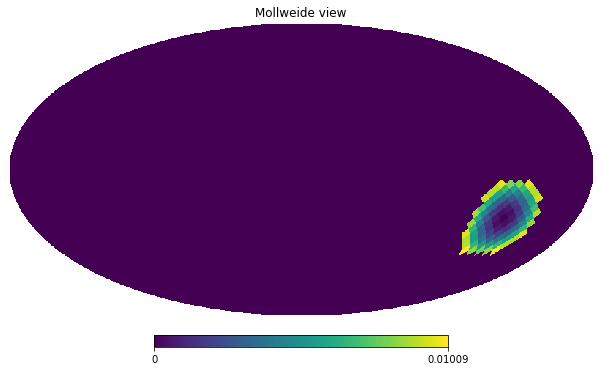

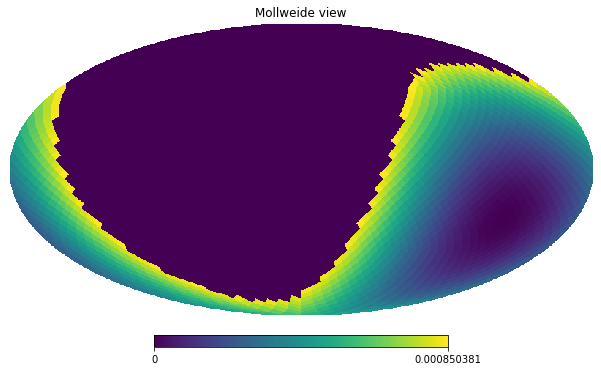

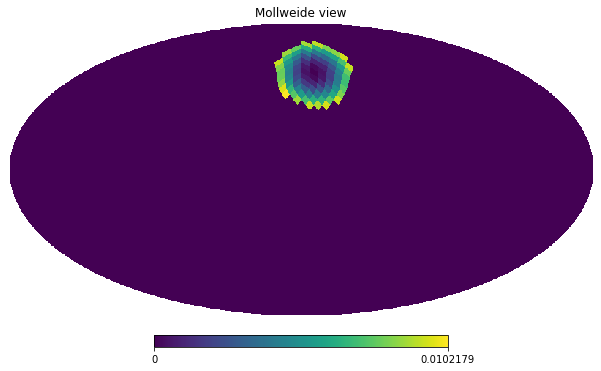

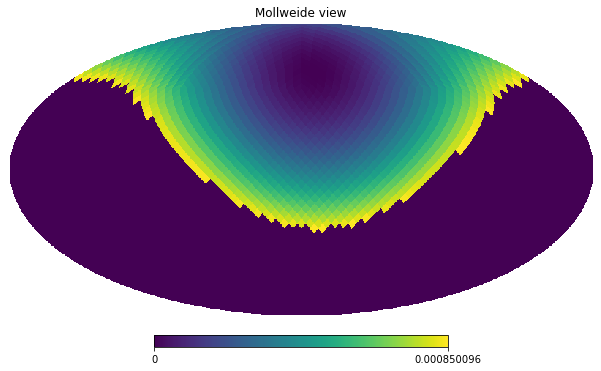

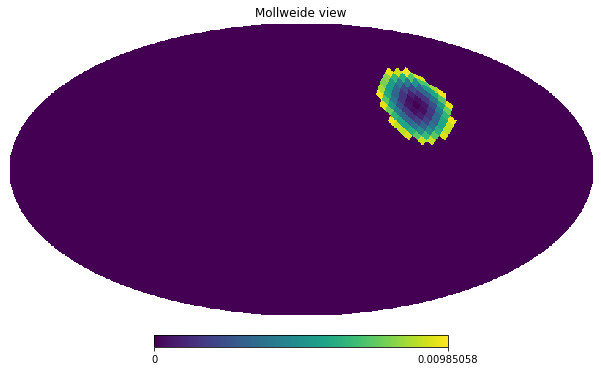

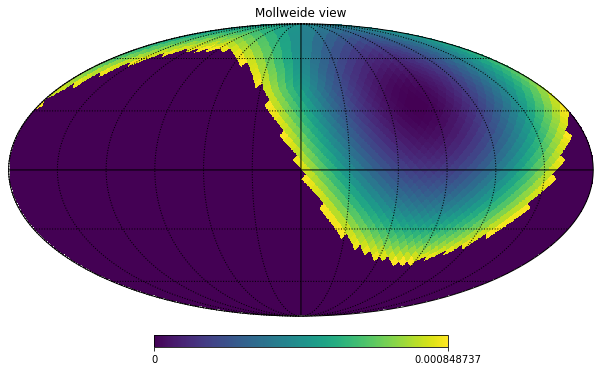

In [27]:
hp.mollview(data,flip='geo')
hp.mollview(data1,flip='geo')
hp.mollview(data2,flip='geo')
hp.mollview(data3,flip='geo')
hp.mollview(data4,flip='geo')
hp.mollview(data5,flip='geo')


hp.graticule()

<b> Transmitter locations from the FM Transmitter database has been taken into account BUT the received power at different altitudes has not been taken into account for these plots <b>

In [28]:
#Array of indices of the pixel number that are common to the FOV and TX database
x=Comm_pix[2167][0]  # FOr Australia at an altitude of 400 km
x1=Comm_pix[2167][1]  # FOr Australia at an altitude of 36000 km
x2=Comm_pix[313][0]   # FOr Germany at an altitude of 400 km
x3=Comm_pix[313][1]  # FOr Germany at an altitude of 36000 km
x4=Comm_pix[686][0]  # FOr Hanle at an altitude of 400 km
x5=Comm_pix[686][1]   # FOr Hanle at an altitude of 36000 km

yy=beam(elev_ang[0,2167,x],az)
yy1=beam(elev_ang[1,2167,x1],az)
yy2=beam(elev_ang[0,313,x2],az)
yy3=beam(elev_ang[1,313,x3],az)
yy4=beam(elev_ang[0,686,x4],az)
yy5=beam(elev_ang[1,686,x5],az)

d= np.zeros(hp.nside2npix(nside))
d1= np.zeros(hp.nside2npix(nside))
d2= np.zeros(hp.nside2npix(nside))
d3= np.zeros(hp.nside2npix(nside))
d4= np.zeros(hp.nside2npix(nside))
d5= np.zeros(hp.nside2npix(nside))
#point=np.arange(len(xx))
#data[0:np.size(arr[0:1499])]=arr[0:1499]
d[x]=yy
d1[x1]=yy1
d2[x2]=yy2
d3[x3]=yy3
d4[x4]=yy4
d5[x5]=yy5


0.0 180.0 -180.0 180.0


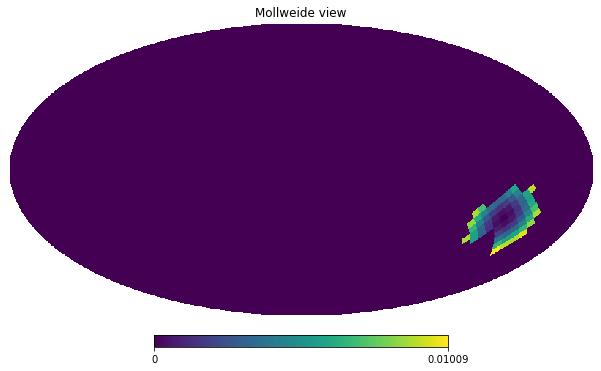

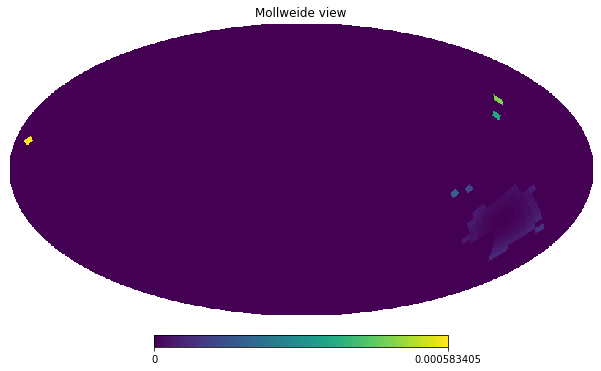

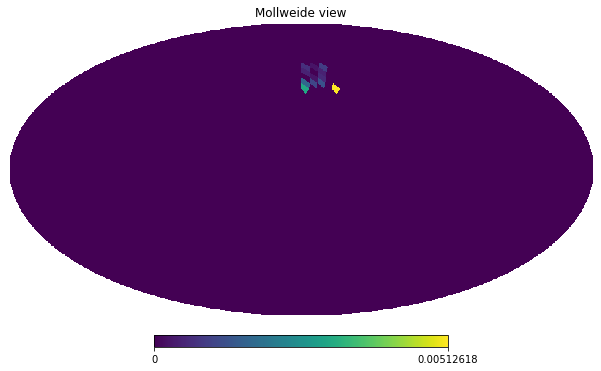

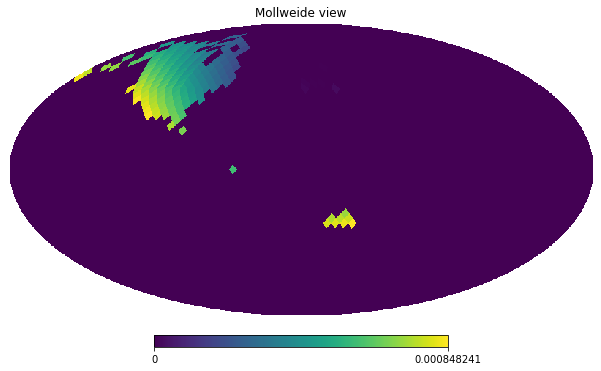

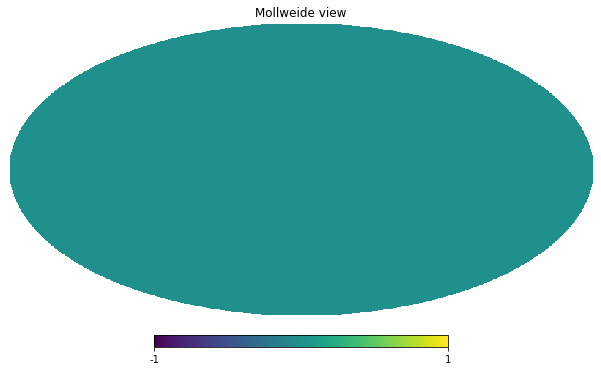

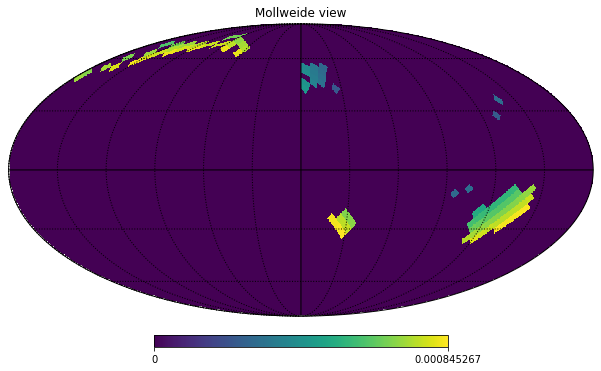

In [29]:
hp.mollview(d,flip='geo')
hp.mollview(d1,flip='geo')
hp.mollview(d2,flip='geo')
hp.mollview(d3,flip='geo')
hp.mollview(d4,flip='geo')
hp.mollview(d5,flip='geo')


hp.graticule()

In [17]:
#######-------Store the values of the received power in Watt,dBm and Kelvin wrt altitude----#####
######------- Calculation of the received power using Friis Transmission Equation--------#######
######-------Considering isotropic transmitter and receiver with gain =1 -------------#########


res=61*1e3
Rx_Power= np.zeros((len(df),len(altitude)))
Rx_Power_in_Kelvin=np.zeros((len(df),len(altitude)))
Rx_Power_in_dBm=np.zeros((len(df),len(altitude)))
Rx_Power_in_dBW=np.zeros((len(df),len(altitude)))
for i in range(0,len(altitude)):
    for j in range(0,len(df)):
        wavelength= c.value/(df.iloc[j]['Frequency(MHz)']*1e6)
        Rx_Power[j][i]= ((df.iloc[j]['EIRP'])*(wavelength)**2)/(4*np.pi*altitude[i]*1e3)**2 #the Friis Transmission Equation
        Rx_Power_in_dBm[j][i]= 10.*np.log10( Rx_Power[j][i])+30
        Rx_Power_in_Kelvin[j][i]=Rx_Power[j][i]/(k_B.value*res)#in Kelvin
        Rx_Power_in_dBW[j][i]= 10.*np.log10( Rx_Power[j][i])
        

       

<ipython-input-17-1593f8593051>:15: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBm[j][i]= 10.*np.log10( Rx_Power[j][i])+30
<ipython-input-17-1593f8593051>:17: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBW[j][i]= 10.*np.log10( Rx_Power[j][i])


In [31]:
##### ---Create dataframe to store the values of the received power in dBm w.r.t the altitude----#####
df_data_db=pd.DataFrame(Rx_Power_in_dBm)
df_data_db['Pixel_number']=pixel_indices
df_data_db['New Frequency']=freq_arr
#df_data_db


In [18]:
df_data_dbW=pd.DataFrame(Rx_Power_in_dBW)
df_data_dbW['Pixel_number']=pixel_indices
df_data_dbW['New Frequency']=freq_arr
df_data_dbW

,0,1,Pixel_number,New Frequency
0,-71.190627,-110.275477,313,87.250000
1,-72.159727,-111.244577,265,87.250000
2,-77.211227,-116.296077,365,87.250000
3,-94.200927,-133.285777,365,87.250000
4,-98.180327,-137.265177,365,87.250000
...,...,...,...,...
14732,-102.731178,-141.816028,338,104.828125
14733,-92.714555,-131.799405,338,104.828125
14734,-105.691511,-144.776361,338,103.851562
14735,-87.968266,-127.053116,338,104.828125


In [32]:
##### ---Create dataframe to store the values of the received power in Kelvin w.r.t the altitude----#####

##### The first three columns of the dataframe indicate the altitude [0=400 km, 1= 3794 km , 2= 36000 km ] #####
##### The column will vary with the user input for the number of altitudes ######

df_data=pd.DataFrame(Rx_Power_in_Kelvin)

df_data['Pixel_number']=pixel_indices
df_data['New Frequency']=freq_arr


#df_data

<b> P.S : Uncomment the line inside the loop if you want to incorporate the beam pattern <b>

In [33]:
#########  Create dataframes for the FOV for each pixel position of the satellite at different altitudes #######

######--- Initializing the array to store the dataframes for the FOV for each pixel position of the satellite #####
######            at different altitudes   ######

beam(elev_ang[1,2167,x1],az)
df_1=np.zeros((len(found_common),len(Rad_of_FOV)),dtype=object)

for j in range(len(Rad_of_FOV)):
    for i in range(len(found_common)):
        df_1[i][j]= df_data.loc[df_data['Pixel_number'].isin(found_common[i][j])]
        #df_1[i][j][j]=df_1[i][j][j]*beam(elev_ang[j,i,found_common[i,j]],az)
        
        df_1[i][j]= df_1[i][j].groupby(['New Frequency']).sum()  # df9['Pixel_number']= Column consisting of 
        df_1[i][j]= df_1[i][j].reset_index() 
        
#df_1[i][j][j]=df_1[i][j][j]*beam_pattern[j,i,found_common[i,j]]        
#df_1.drop['Pixel_number']

In [34]:
## Initializing the 3D array to store the received power for each pixel, each frequency and at different altitudes ###

power_output=np.zeros((len(Rad_of_FOV),NPIX,len(freq_rfi)),dtype=object)


In [35]:
## Create the 3D array to store the received power for each pixel, each frequency and at different altitudes ##
## k: loops along the length of the number of altitude
## m: loops along the length of the number of pixels based on the given NSIDE
## l: loops along the length of the number of frequencies in the frequency axis defined by user



for k in range(len(Rad_of_FOV)):
    for m in range(NPIX):    
        for l in range(len(freq_rfi)):
            if (df_1[m][k][k][df_1[m][k]['New Frequency'] == freq_rfi[l]].values).size==0:# checking for empty dataframes
                power_output[k][m][l]=0
            else: 
                power_output[k][m][l]=float(df_1[m][k][k][df_1[m][k]['New Frequency'] == freq_rfi[l]].values)
           
        

In [36]:
%store power_output

Stored 'power_output' (ndarray)


In [37]:
#power_output[1,arr!=313,:]=0

## Plot Power Spectrum 

<b> The first index represents altitude of the satellite <b>\
<b> The second index represents location of the satellite(pixel number) <b>\
<b> The third index represents range of frequencies <b>

Text(0.5, 0.98, 'Power spectrum for GERMANY at an altitude of 400 km')

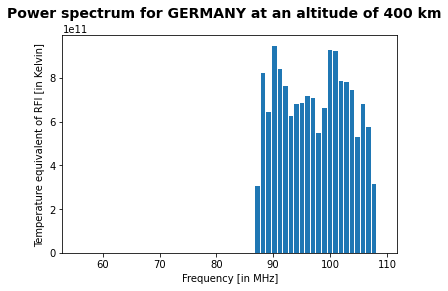

In [39]:
plt.bar(freq_rfi,power_output[0,313,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for GERMANY at an altitude of 400 km',fontsize=14, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum for GERMANY at an altitude of 36000 km')

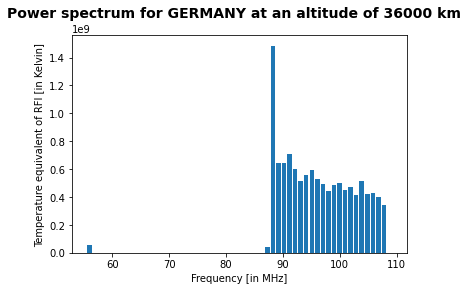

In [40]:
plt.bar(freq_rfi,power_output[1,313,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for GERMANY at an altitude of 36000 km',fontsize=14, fontweight="bold")

In [ ]:
plt.bar(freq,power_output[0,686,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for HANLE at an altitude of 400 km',fontsize=14, fontweight="bold")

In [ ]:
plt.bar(freq,power_output[1,686,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for HANLE at an altitude of 36000 km',fontsize=14, fontweight="bold")

In [ ]:
plt.bar(freq,power_output[1,2167,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for AUSTRALIA at an altitude of 36000 km',fontsize=14, fontweight="bold")

In [ ]:
plt.bar(freq,power_output[0,2167,:]) 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Temperature equivalent of RFI [in Kelvin]')
plt.suptitle('Power spectrum for AUSTRALIA at an altitude of 400 km',fontsize=14, fontweight="bold")

## Plot Healpy map of brightness temperature of RFI 

In [ ]:
test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[0,:,35])] = power_output[0,:,35]
hp.mollview(test_plot,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90.18 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [ ]:
test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[0,:,46])] = power_output[0,:,46]
hp.mollview(test_plot,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 100.92 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [ ]:
test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[1,:,46])] = power_output[1,:,46]
hp.mollview(test_plot,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 36000 km for Received power in Kelvin at 100.92 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [ ]:
test_plot = np.zeros(hp.nside2npix(nside))
test_plot[0:np.size(power_output[1,:,35])] = power_output[1,:,35]
hp.mollview(test_plot,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 36000 km for Received power in Kelvin at 90.18 MHz",flip='geo',norm='hist')#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()

In [ ]:
test_plot0001 = np.zeros(hp.nside2npix(nside))
test_plot0001[0:np.size(power_output[0,:,6])] = power_output[0,:,6]
hp.mollview(test_plot0001,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm='hist')#xsize=24)#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()
s = 500
plt.scatter(np.deg2rad(10.45), np.deg2rad(51.16), color="r", marker="x", linewidth=10, s=s);
plt.scatter(np.deg2rad(22.93), np.deg2rad(-30.559), color="r", marker="x", linewidth=10, s=s);
#plt.scatter(np.deg2rad(10), np.deg2rad(90), color="r", marker="x", linewidth=10, s=s);

#hp.boundaries()
#newprojplot(np.radians(df['Latitude in degrees'].to_numpy()), np.radians(df['Longitude in degrees'].to_numpy()))

In [ ]:
# Replacing the power value of 0 to a minimum value 1.000001 in order to apply logarithmic equalization in 
# the Healpy map


power_output_log=np.where(power_output[0,:,6]==0, 1.0000001, power_output[0,:,6])
power_output_log

In [ ]:
###-------Plotting of the Healpy Map in mollweide projection------###
#####------For an altitude of 400 km at 90 MHz with logarithmic equalization----------------------#######


test_plot12 = np.zeros(hp.nside2npix(nside))
test_plot12[0:np.size(power_output[0,:,6])] = power_output_log
test_plot12=np.where(test_plot12==0, 1.0000001,test_plot12 )

In [ ]:
hp.mollview(test_plot12,cmap='inferno',unit="in Kelvin",title="Mollweide projection at an altitude 400 km for Received power in Kelvin at 90 MHz",flip='geo',norm="log")#,cb_orientation="vertical",title="Mollweide projection for Received power in Kelvin at 88.9MHz",flip='g')
hp.graticule()